In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, LSTM, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay    v

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/yes/sequence43/29.jpg  
  inflating: dataset/yes/sequence43/3.jpg  
  inflating: dataset/yes/sequence43/4.jpg  
  inflating: dataset/yes/sequence43/5.jpg  
  inflating: dataset/yes/sequence43/6.jpg  
  inflating: dataset/yes/sequence43/7.jpg  
  inflating: dataset/yes/sequence43/8.jpg  
  inflating: dataset/yes/sequence43/9.jpg  
   creating: dataset/yes/sequence44/
  inflating: dataset/yes/sequence44/0.jpg  
  inflating: dataset/yes/sequence44/1.jpg  
  inflating: dataset/yes/sequence44/10.jpg  
  inflating: dataset/yes/sequence44/11.jpg  
  inflating: dataset/yes/sequence44/12.jpg  
  inflating: dataset/yes/sequence44/13.jpg  
  inflating: dataset/yes/sequence44/14.jpg  
  inflating: dataset/yes/sequence44/15.jpg  
  inflating: dataset/yes/sequence44/16.jpg  
  inflating: dataset/yes/sequence44/17.jpg  
  inflating: dataset/yes/sequence44/18.jpg  
  inflating: dataset/yes/sequence44/19.jpg  
  inflating: dataset/

In [17]:
# Define the list of actions
actions = ['red','eat','howcanihelpyou','sandwich','dream','ketchup','drink','timewhat','whatdidyousay','sleep','blue','no','bread','cereal','nothing','green','seeyoulater','howoldareyou','nicetomeetyou','whereisthebathroom','yes','goodbye', 'hello', 'hi', 'howareyou', 'ok', 'thanks', 'fine', 'sorry', 'whatsup', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Define the directory where the frames are saved
base_dir = '/content/dataset'

# Initialize lists to store the frames and labels
frames = []
labels = []

# Loop for each action
for i, action in enumerate(actions):
    # Loop for each sequence
    try:
        for sequence in os.listdir(os.path.join(base_dir, action)):
            # Loop for each frame
            for frame_name in os.listdir(os.path.join(base_dir, action, sequence)):
                # Load the frame
                frame = cv2.imread(os.path.join(base_dir, action, sequence, frame_name))
                # Resize the frame to a smaller size (e.g., 112x112 pixels)
                frame = cv2.resize(frame, (112, 112))
                # Normalize pixel values
                frame = frame / 255.0
                # Append the frame to the frames list
                frames.append(frame)
                # Append the label to the labels list
                labels.append(i)
    except KeyboardInterrupt:
        print("Execution interrupted by user.")

# Convert the frames and labels to numpy arrays
frames = np.array(frames)
labels = np.array(labels)

# One-hot encode the labels
labels = to_categorical(labels)

# Reshape the data to fit the 3D CNN input requirement
frames = frames.reshape((frames.shape[0], 1, frames.shape[1], frames.shape[2], frames.shape[3]))

# Split the data into training and testing sets
frames_train, frames_test, labels_train, labels_test = train_test_split(frames, labels, test_size=0.2)

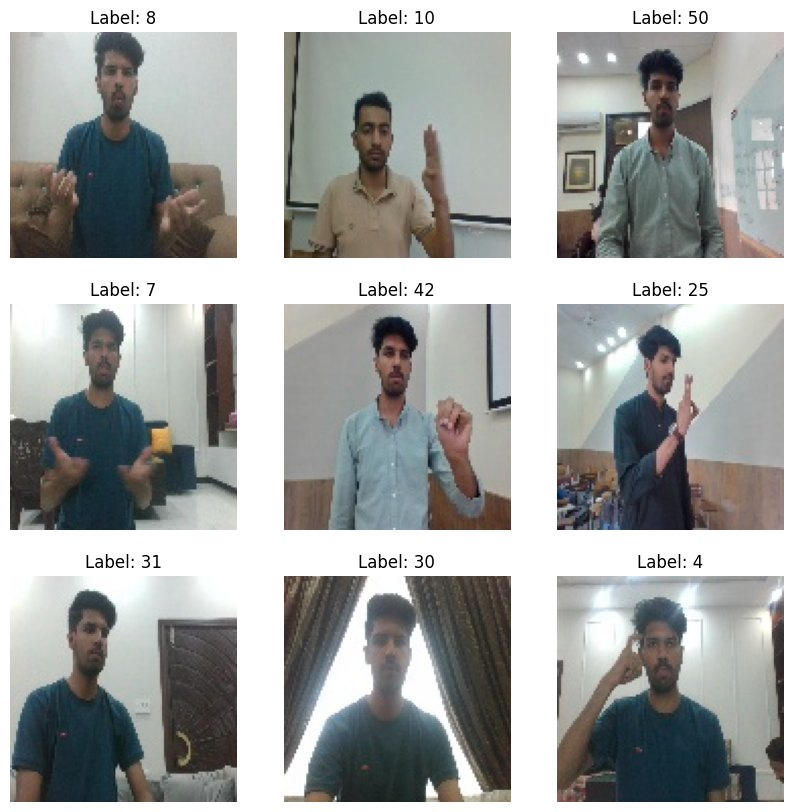

In [18]:
# prompt: show some of the resized frames

# Display some resized frames
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(frames_train[i][0])
    plt.title(f"Label: {np.argmax(labels_train[i])}")
    plt.axis('off')
plt.show()


In [19]:
# Define a 3DCNN model
model = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', strides=(1, 2, 2), padding='same', input_shape=(None, 112, 112, 3)),
    MaxPooling3D((1, 2, 2), strides=(1, 2, 2)),
    Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D((1, 2, 2), strides=(1, 2, 2)),
    Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
    Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D((1, 2, 2), strides=(2, 2, 2)),
    Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
    Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D((1, 2, 2), strides=(2, 2, 2)),
    BatchNormalization(),
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=True),
    LSTM(128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(actions), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Define a generator function that will apply transformations to each sequence
def sequence_generator(frames, labels, batch_size):
    while True:
        indices = np.random.choice(frames.shape[0], batch_size)
        batch_frames = frames[indices]
        batch_labels = labels[indices]
        batch_transformed_frames = np.zeros((batch_size, *frames.shape[1:]))
        for i in range(batch_size):
            for j in range(frames.shape[1]):
                img = batch_frames[i, j]
                img = datagen.random_transform(img)  # Apply random transformation
                batch_transformed_frames[i, j] = img
        yield batch_transformed_frames, batch_labels

# Define the batch size
batch_size = 16

# Create the sequence generators for the training and testing sets
train_gen = sequence_generator(frames_train, labels_train, batch_size)
test_gen = sequence_generator(frames_test, labels_test, batch_size)

# Compute the number of steps per epoch
steps_per_epoch = frames_train.shape[0] // batch_size
validation_steps = frames_test.shape[0] // batch_size

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, None, 56, 56, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, None, 28, 28, 32   0         
 g3D)                        )                                   
                                                                 
 conv3d_13 (Conv3D)          (None, None, 28, 28, 64   55360     
                             )                                   
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, None, 14, 14, 64   0         
 g3D)                        )                                   
                                                                 
 conv3d_14 (Conv3D)          (None, None, 14, 14, 12  

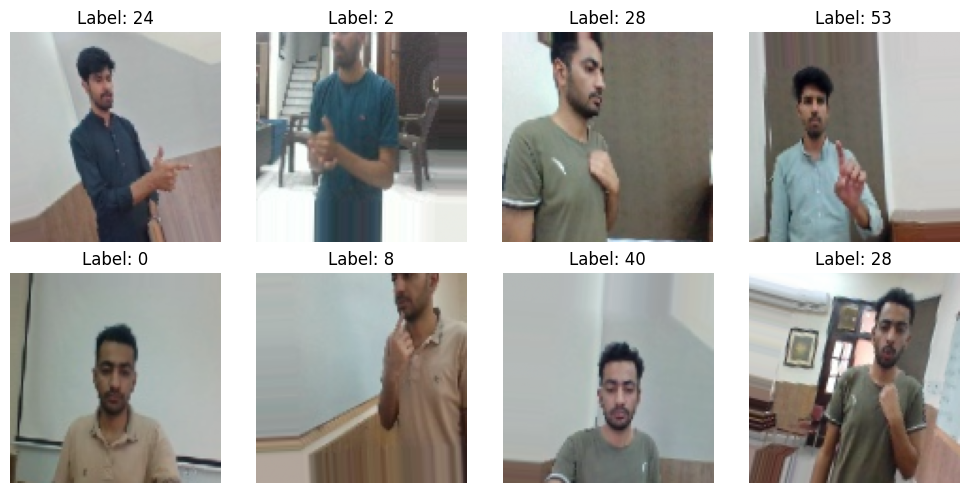

In [20]:
# ... (preceding code)

# Plot some images from the training generator
x, y = next(train_gen)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  axes[i].imshow(x[i][0])
  axes[i].set_title(f"Label: {np.argmax(y[i])}")
  axes[i].axis('off')
plt.tight_layout()
plt.show()


In [15]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
# Train the model using the sequence generators
history = model.fit(train_gen, epochs=30, steps_per_epoch=steps_per_epoch, validation_data=test_gen, validation_steps=validation_steps)

Epoch 1/30
8400/8400 [==============================] - 1763s 209ms/step - loss: 2.7788 - accuracy: 0.1694 - val_loss: 2.2506 - val_accuracy: 0.2580
Epoch 2/30
8400/8400 [==============================] - 1744s 208ms/step - loss: 2.0583 - accuracy: 0.2993 - val_loss: 1.9175 - val_accuracy: 0.3437
Epoch 3/30
8400/8400 [==============================] - 1743s 208ms/step - loss: 1.7751 - accuracy: 0.3762 - val_loss: 1.5052 - val_accuracy: 0.4485
Epoch 4/30
8400/8400 [==============================] - 1753s 209ms/step - loss: 1.5938 - accuracy: 0.4295 - val_loss: 1.3717 - val_accuracy: 0.5016
Epoch 5/30
8400/8400 [==============================] - 1744s 208ms/step - loss: 1.4517 - accuracy: 0.4689 - val_loss: 1.3943 - val_accuracy: 0.4911
Epoch 6/30
8400/8400 [==============================] - 1744s 208ms/step - loss: 1.3368 - accuracy: 0.5064 - val_loss: 1.1545 - val_accuracy: 0.5682
Epoch 7/30
8400/8400 [==============================] - 1753s 209ms/step - loss: 1.2421 - accuracy: 0.5363

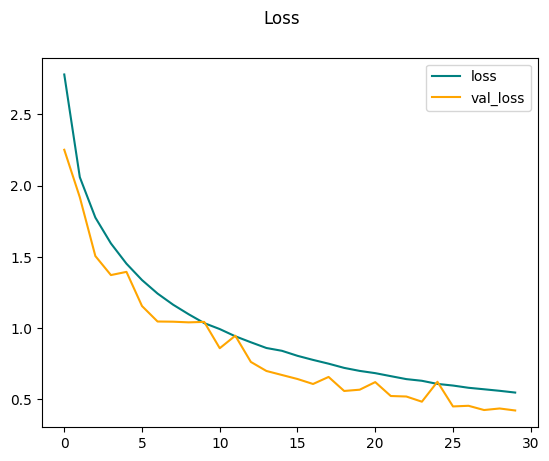

In [22]:
fig = plt.figure()
plt.plot(history.history['loss'], color = 'teal', label = 'loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss')
plt.legend(loc = "upper right")
plt.show()

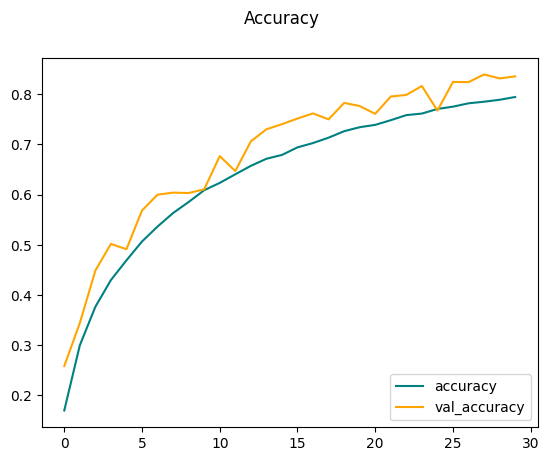

In [23]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy')
plt.legend(loc = "lower right")
plt.show()

1050/1050 [==============================] - 26s 25ms/step
Precision: 0.99648964
Recall: 0.99896854
Accuracy: 0.03360119
F1 Score: [1.9297814]


<Figure size 2000x2000 with 0 Axes>

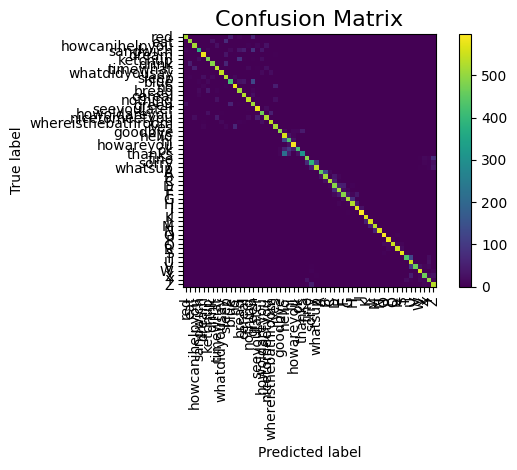

In [34]:
# Predict on the test set
y_pred = model.predict(frames_test)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(labels_test, axis=1)

# Calculate precision, recall, accuracy, and F1 score
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()
f1 = F1Score()

# Reshape y_pred_classes and y_true_classes to 2D arrays
y_pred_classes = y_pred_classes.reshape(-1, 1)
y_true_classes = y_true_classes.reshape(-1, 1)

precision.update_state(y_true_classes, y_pred_classes)
recall.update_state(y_true_classes, y_pred_classes)
accuracy.update_state(y_true_classes, y_pred_classes)
f1.update_state(y_true_classes, y_pred_classes)

print("Precision:", precision.result().numpy())
print("Recall:", recall.result().numpy())
print("Accuracy:", accuracy.result().numpy())
print("F1 Score:", f1.result().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix with all labels
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actions)
disp.plot(xticks_rotation='vertical', include_values=False, cmap='viridis')  # Set include_values to False to hide values, use 'viridis' colormap
plt.xticks(fontsize=10)  # Adjust font size for x-axis labels
plt.yticks(fontsize=10)  # Adjust font size for y-axis labels
plt.title('Confusion Matrix', fontsize=16)  # Increase title font size
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [26]:
# Save the model in .keras format
model.save('/content/action_recognition_model.keras')

# Save the model in .h5 format
model.save('content/action_recognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
